<a href="https://colab.research.google.com/github/NitaiBanik/ProjectsFor/blob/master/RepeatingClasses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from keras.models import load_model

In [3]:
# imports for building the network
import tensorflow as tf
from tensorflow import reduce_sum
from tensorflow.keras.backend import pow
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D, Concatenate, Add, Flatten
from tensorflow.keras.losses import binary_crossentropy
from sklearn.model_selection import train_test_split

In [6]:
load_pretrained_model = True # load a pre-trained model
save_model = True # save the model after training
train_dir = '/content/drive/My Drive/Colab/' # directory of training images
pretrained_model_path = '/content/drive/My Drive/Colab_Model/repeatModel_st.h5' # path of pretrained model
model_save_path = '/content/drive/My Drive/Colab_Model/repeatModel_st.h5' # path of model to save
#train_image_dir = os.path.join(train_dir, 'train') # 
train_image_dir = '/content/drive/My Drive/Colab/train_2/train'

In [7]:
# network configuration parameters
# original image is 1600x256, so we will resize it
img_w = 512 # resized weidth
img_h = 256 # resized height
batch_size = 16
# batch size for training unet
k_size = 3 # kernel size 3x3
val_size = .20 # split of training set between train and validation set
# we will repeat the images with lower samples to make the training process more fair
class_1_repeat = 3 # repeat class 1 examples x times
class_2_repeat = 10
class_3_repeat = 1
class_4_repeat = 3

In [8]:
# load full data and label no mask as -1
#train_df = pd.read_csv(os.path.join(train_dir, '/content/drive/My Drive/Colab/100.csv')).fillna(-1)
train_df = pd.read_csv('/content/drive/My Drive/Colab/train.csv').fillna(-1)
# image id and class id are two seperate entities and it makes it easier to split them up in two columns

In [9]:
# image id and class id are two seperate entities and it makes it easier to split them up in two columns
train_df['ImageId'] = train_df['ImageId_ClassId'].apply(lambda x: x.split('_')[0])
train_df['ClassId'] = train_df['ImageId_ClassId'].apply(lambda x: x.split('_')[1])
# lets create a dict with class id and encoded pixels and group all the defaults per image
train_df['ClassId_EncodedPixels'] = train_df.apply(lambda row: (row['ClassId'], row['EncodedPixels']), axis = 1)
grouped_EncodedPixels = train_df.groupby('ImageId')['ClassId_EncodedPixels'].apply(list)

In [11]:
def rle_to_mask(rle_string,height,width):
    rows, cols = height, width
    if rle_string == -1:
        return np.zeros((height, width))
    else:
        rleNumbers = [int(numstring) for numstring in rle_string.split(' ')]
        rlePairs = np.array(rleNumbers).reshape(-1,2)
        img = np.zeros(rows*cols,dtype=np.uint8)
        for index,length in rlePairs:
            index -= 1
            img[index:index+length] = 255
        img = img.reshape(cols,rows)
        img = img.T
        return img

In [12]:
def mask_to_rle(mask):
    pixels= mask.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [42]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, list_ids, labels, image_dir, batch_size=32,
                 img_h=256, img_w=512, shuffle=True):
        
        self.list_ids = list_ids
        self.labels = labels
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.img_h = img_h
        self.img_w = img_w
        self.shuffle = shuffle
        self.on_epoch_end()
    
    def __len__(self):
        'denotes the number of batches per epoch'
        return int(np.floor(len(self.list_ids)) / self.batch_size)
    
    def __getitem__(self, index):
        'generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # get list of IDs
        list_ids_temp = [self.list_ids[k] for k in indexes]
        # generate data
        X, y = self.__data_generation(list_ids_temp)
        # return data 
        return X, y
    
    def on_epoch_end(self):
        'update ended after each epoch'
        self.indexes = np.arange(len(self.list_ids))
        if self.shuffle:
            np.random.shuffle(self.indexes)
            
    def __data_generation(self, list_ids_temp):
        'generate data containing batch_size samples'
        X = np.empty((self.batch_size, self.img_h, self.img_w, 3))
        y = np.empty((self.batch_size, self.img_h, self.img_w, 4))
        
        for idx, id in enumerate(list_ids_temp):
            file_path =  os.path.join(self.image_dir, id)
            image = cv2.imread(file_path, 0)
            image_resized = cv2.resize(image, (self.img_w, self.img_h))
            image_resized = np.array(image_resized, dtype=np.float64)
            # standardization of the image
            image_resized -= image_resized.mean()
            image_resized /= image_resized.std()
            
            mask = np.empty((img_h, img_w, 4))
            
            for idm, image_class in enumerate(['1','2','3','4']):
                rle = self.labels.get(id + '_' + image_class)
                # if there is no mask create empty mask
                if rle is None:
                    class_mask = np.zeros((1600, 256))
                else:
                    class_mask = rle_to_mask(rle, width=1600, height=256)
             
                class_mask_resized = cv2.resize(class_mask, (self.img_w, self.img_h))
                mask[...,idm] = class_mask_resized
            
            X[idx,] = np.expand_dims(image_resized, axis=2)
            y[idx,] = mask
        
        # normalize Y
        y = (y > 0).astype(float)
            
        return X, y

In [43]:
# create a dict of all the masks
masks = {}
for index, row in train_df[train_df['EncodedPixels']!=-1].iterrows():
    masks[row['ImageId_ClassId']] = row['EncodedPixels']

In [44]:
class_1_img_id = train_df[(train_df['EncodedPixels']!=-1) & (train_df['ClassId']=='1')]['ImageId'].values
class_1_img_id = np.repeat(class_1_img_id, class_1_repeat)
class_2_img_id = train_df[(train_df['EncodedPixels']!=-1) & (train_df['ClassId']=='2')]['ImageId'].values
class_2_img_id = np.repeat(class_2_img_id, class_2_repeat)
class_3_img_id = train_df[(train_df['EncodedPixels']!=-1) & (train_df['ClassId']=='3')]['ImageId'].values
class_3_img_id = np.repeat(class_3_img_id, class_3_repeat)
class_4_img_id = train_df[(train_df['EncodedPixels']!=-1) & (train_df['ClassId']=='4')]['ImageId'].values
class_4_img_id = np.repeat(class_4_img_id, class_4_repeat)
train_image_ids = np.concatenate([class_1_img_id, class_2_img_id, class_3_img_id, class_4_img_id])

In [45]:
X_train, X_val = train_test_split(train_image_ids, test_size=val_size, random_state=42)

In [47]:
params = {'img_h': img_h,
          'img_w': img_w,
          'image_dir': train_image_dir,
          'batch_size': batch_size,
          'shuffle': True}
          
training_generator = DataGenerator(X_train, masks, **params)
validation_generator = DataGenerator(X_val, masks, **params)

In [48]:
x, y = training_generator.__getitem__(0)
print(x.shape, y.shape)
#print(type(y[0]))

(16, 256, 512, 3) (16, 256, 512, 4)


In [49]:
# visualize steel image with four classes of faults in seperate columns
def viz_steel_img_mask(img, masks):
    img = cv2.cvtColor(img.astype('float32'), cv2.COLOR_BGR2RGB)
    fig, ax = plt.subplots(nrows=1, ncols=4, sharey=True, figsize=(20,10))
    cmaps = ["Reds", "Blues", "Greens", "Purples"]
    for idx, mask in enumerate(masks):
        ax[idx].imshow(img)
        ax[idx].imshow(mask, alpha=0.3, cmap=cmaps[idx])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

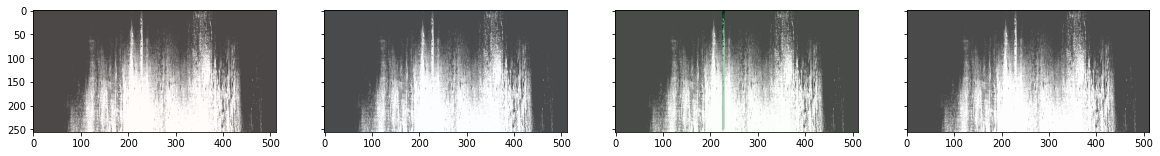

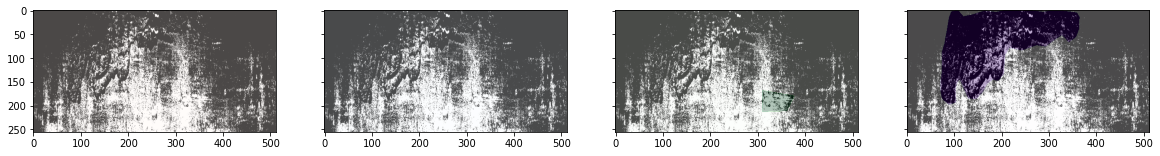

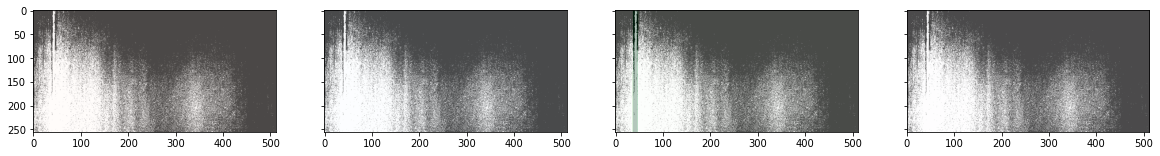

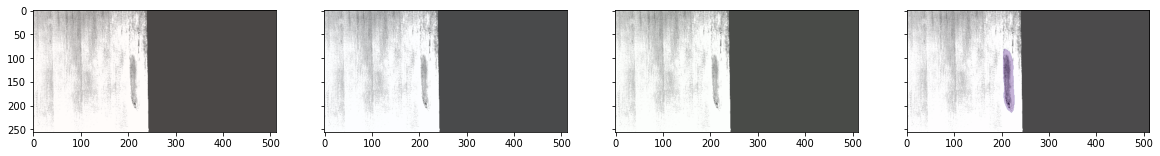

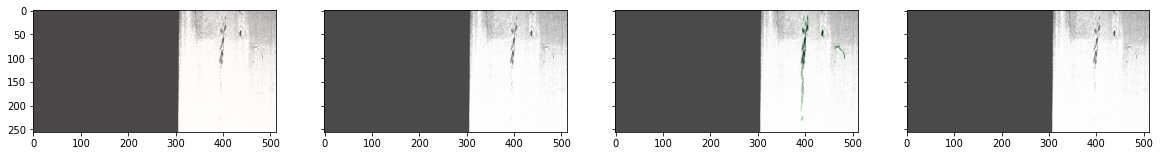

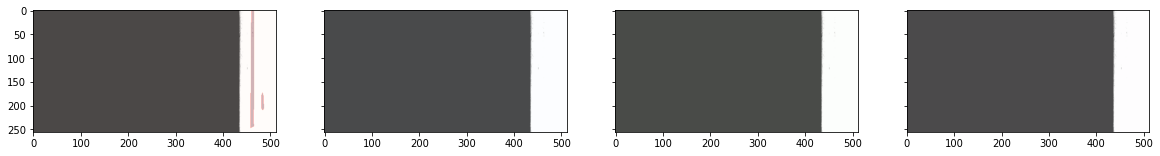

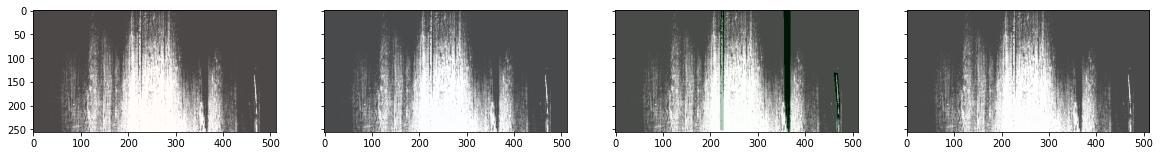

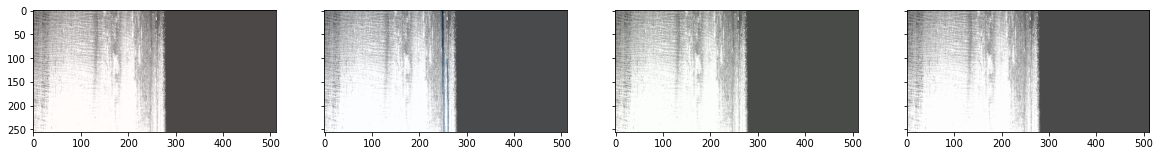

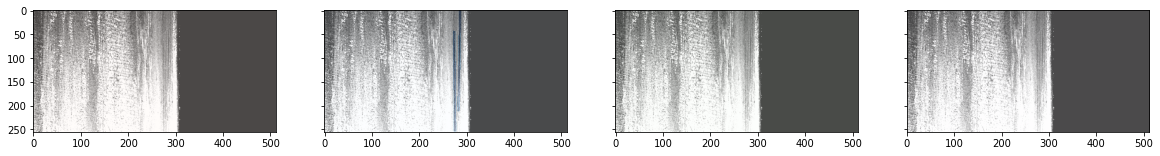

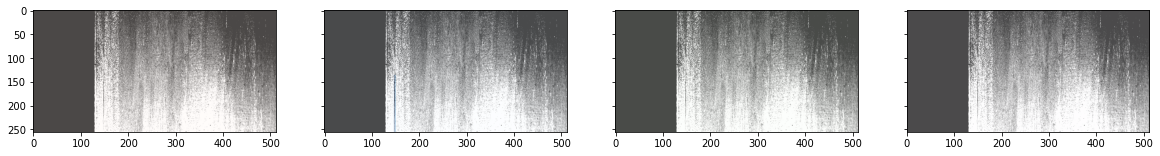

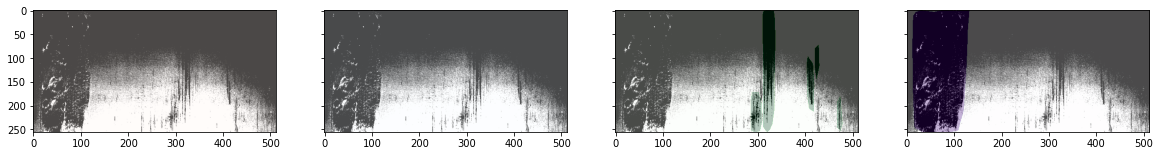

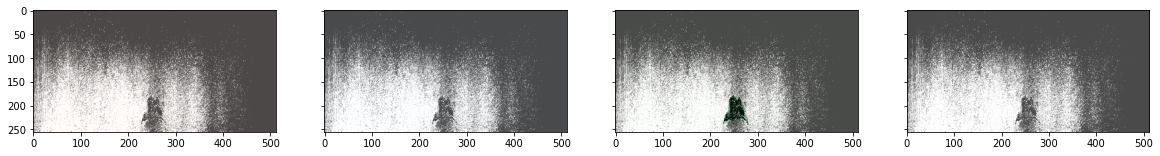

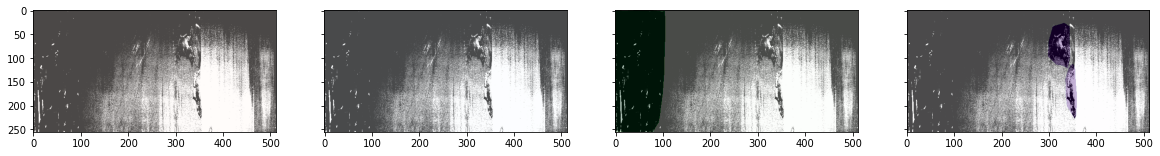

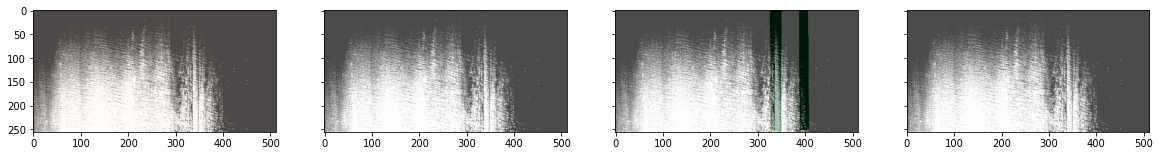

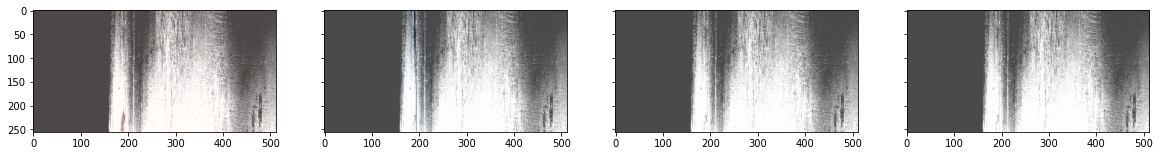

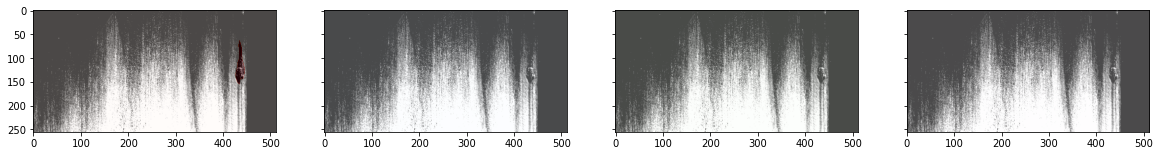

In [50]:
for ix in range(0,batch_size):
    if y[ix].sum() > 0:
        img = x[ix]
        masks_temp = [y[ix][...,i] for i in range(0,4)]
        viz_steel_img_mask(img, masks_temp)

In [52]:
def bn_act(x, act=True):
    'batch normalization layer with an optinal activation layer'
    x = tf.keras.layers.BatchNormalization()(x)
    if act == True:
        x = tf.keras.layers.Activation('relu')(x)
    return x

In [53]:
def conv_block(x, filters, kernel_size=3, padding='same', strides=1):
    'convolutional layer which always uses the batch normalization layer'
    conv = bn_act(x)
    conv = Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)
    return conv

In [54]:
def stem(x, filters, kernel_size=3, padding='same', strides=1):
    conv = Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size, padding, strides)
    shortcut = Conv2D(filters, kernel_size=1, padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    output = Add()([conv, shortcut])
    return output

In [55]:
def residual_block(x, filters, kernel_size=3, padding='same', strides=1):
    res = conv_block(x, filters, k_size, padding, strides)
    res = conv_block(res, filters, k_size, padding, 1)
    shortcut = Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    output = Add()([shortcut, res])
    return output

In [56]:
def upsample_concat_block(x, xskip):
    u = UpSampling2D((2,2))(x)
    c = Concatenate()([u, xskip])
    return c

In [57]:
def ResUNet(img_h, img_w):
    f = [16, 32, 64, 128, 256]
    inputs = Input((img_h, img_w, 3))
    
    ## Encoder
    e0 = inputs
    e1 = stem(e0, f[0])
    e2 = residual_block(e1, f[1], strides=2)
    e3 = residual_block(e2, f[2], strides=2)
    e4 = residual_block(e3, f[3], strides=2)
    e5 = residual_block(e4, f[4], strides=2)
    
    ## Bridge
    b0 = conv_block(e5, f[4], strides=1)
    b1 = conv_block(b0, f[4], strides=1)
    
    ## Decoder
    u1 = upsample_concat_block(b1, e4)
    d1 = residual_block(u1, f[4])
    
    u2 = upsample_concat_block(d1, e3)
    d2 = residual_block(u2, f[3])
    
    u3 = upsample_concat_block(d2, e2)
    d3 = residual_block(u3, f[2])
    
    u4 = upsample_concat_block(d3, e1)
    d4 = residual_block(u4, f[1])
    
    outputs = tf.keras.layers.Conv2D(4, (1, 1), padding="same", activation="sigmoid")(d4)
    model = tf.keras.models.Model(inputs, outputs)
    return model

In [58]:
# Dice similarity coefficient loss, brought to you by: https://github.com/nabsabraham/focal-tversky-unet
def dsc(y_true, y_pred):
    smooth = 1.
    y_true_f = Flatten()(y_true)
    y_pred_f = Flatten()(y_pred)
    intersection = reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (reduce_sum(y_true_f) + reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dsc(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

In [59]:
# Focal Tversky loss, brought to you by:  https://github.com/nabsabraham/focal-tversky-unet
def tversky(y_true, y_pred, smooth=1e-6):
    y_true_pos = tf.keras.layers.Flatten()(y_true)
    y_pred_pos = tf.keras.layers.Flatten()(y_pred)
    true_pos = tf.reduce_sum(y_true_pos * y_pred_pos)
    false_neg = tf.reduce_sum(y_true_pos * (1-y_pred_pos))
    false_pos = tf.reduce_sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

def focal_tversky_loss(y_true,y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return tf.keras.backend.pow((1-pt_1), gamma)

In [60]:
model = ResUNet(img_h=img_h, img_w=img_w)
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model.compile(optimizer=adam, loss=focal_tversky_loss, metrics=[dsc, tversky])

In [61]:
if load_pretrained_model:
    try:
        model.load_weights(pretrained_model_path)
        print('pre-trained model loaded!')
    except OSError:
        print('need to run the model and load the trained model')

need to run the model and load the trained model


In [ ]:
history = model.fit_generator(generator=training_generator, validation_data=validation_generator, epochs=50, verbose=1)

Epoch 1/50
635/635 [==============================] - 2496s 4s/step - loss: 0.6930 - dsc: 0.3398 - tversky: 0.3828 - val_loss: 0.6247 - val_dsc: 0.4643 - val_tversky: 0.4637
Epoch 2/50
635/635 [==============================] - 669s 1s/step - loss: 0.5696 - dsc: 0.4877 - tversky: 0.5253 - val_loss: 0.5959 - val_dsc: 0.4961 - val_tversky: 0.4964
Epoch 3/50
635/635 [==============================] - 666s 1s/step - loss: 0.5246 - dsc: 0.5412 - tversky: 0.5744 - val_loss: 0.7948 - val_dsc: 0.1942 - val_tversky: 0.2623
Epoch 4/50
635/635 [==============================] - 666s 1s/step - loss: 0.5014 - dsc: 0.5677 - tversky: 0.5991 - val_loss: 0.6692 - val_dsc: 0.3409 - val_tversky: 0.4128
Epoch 5/50
635/635 [==============================] - 666s 1s/step - loss: 0.4815 - dsc: 0.5897 - tversky: 0.6201 - val_loss: 0.5032 - val_dsc: 0.5413 - val_tversky: 0.5974
Epoch 6/50
635/635 [==============================] - 666s 1s/step - loss: 0.4547 - dsc: 0.6199 - tversky: 0.6478 - val_loss: 0.4942 -

In [ ]:
model.save(model_save_path)

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(history.history['tversky'])
plt.plot(history.history['val_tversky'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

# summarize history for loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

In [ ]:
# a function to plot image with mask and image with predicted mask next to each other
def viz_single_fault(img, mask, pred, image_class):
    
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,5))
    
    cmaps = ["Reds", "Blues", "Greens", "Purples"]
    
    ax[0].imshow(img)
    ax[0].imshow(mask, alpha=0.3, cmap=cmaps[image_class-1])
    ax[0].set_title('Mask - Defect Class %s' % image_class)
    
    ax[1].imshow(img)
    ax[1].imshow(pred, alpha=0.3, cmap=cmaps[image_class-1])
    ax[1].set_title('Predicted Mask - Defect Class %s' % image_class)
    
    plt.show()

In [ ]:
# https://www.jeremyjordan.me/evaluating-image-segmentation-models/
def calculate_iou(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    if np.sum(union) == 0:
        iou_score = 0
    else:
        iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

In [ ]:
#!/usr/bin/python
# -*- coding: utf-8 -*-

# lets loop over the predictions and print 5 of each image cases with defects

count = 0

# a list to keep count of the number of plots made per image class

class_viz_count = [0, 0, 0, 0]

# to keep the total iou score per image class

class_iou_score = [0, 0, 0, 0]

# to keep sum of mask pixels per image class

class_mask_sum = [0, 0, 0, 0]

# to keep sum of predicted mask pixels per image class

class_pred_sum = [0, 0, 0, 0]

# loop over to all the batches in one epoch

for i in range(0, validation_generator.__len__()):

    # get a batch of image, true mask, and predicted mask

    (x, y) = validation_generator.__getitem__(i)
    predictions = model.predict(x)

    # loop through x to get all the images in the batch

    for (idx, val) in enumerate(x):

        # we are only interested if there is a fault. if we are dropping images with no faults before this will become redundant

        if y[idx].sum() > 0:

            # get an image and convert to make it matplotlib.pyplot friendly

            img = x[idx]
            img = cv2.cvtColor(img.astype('float32'), cv2.COLOR_BGR2RGB)

            # loop over the four ourput layers to create a list of all the masks for this image

            masks_temp = [y[idx][..., i] for i in range(0, 4)]

                # loop over the four output layers to create a list of all the predictions for this image

            preds_temp = [predictions[idx][..., i] for i in range(0, 4)]

                # turn to binary (prediction) mask

            preds_temp = [p > .5 for p in preds_temp]

            for (i, (mask, pred)) in enumerate(zip(masks_temp,
                    preds_temp)):
                image_class = i + 1
                class_iou_score[i] += calculate_iou(mask, pred)
                class_mask_sum[i] += mask.sum()
                class_pred_sum[i] += pred.sum()
                if mask.sum() > 0 and class_viz_count[i] < 5:
                    viz_single_fault(img, mask, pred, image_class)
                    class_viz_count[i] += 1


In [ ]:
def get_test_tensor(img_dir, img_h, img_w, channels=1):

    X = np.empty((1, img_h, img_w, channels))
    # Store sample
    image = cv2.imread(img_dir, 0)
    image_resized = cv2.resize(image, (img_w, img_h))
    image_resized = np.array(image_resized, dtype=np.float64)
    # normalize image
    image_resized -= image_resized.mean()
    image_resized /= image_resized.std()
    
    X[0,] = np.expand_dims(image_resized, axis=2)

    return X

In [ ]:
from skimage import morphology

def remove_small_regions(img, size):
    """Morphologically removes small (less than size) connected regions of 0s or 1s."""
    img = morphology.remove_small_objects(img, size)
    img = morphology.remove_small_holes(img, size)
    return img

In [ ]:
import glob
# get all files using glob
test_files = [f for f in glob.glob('/content/drive/My Drive/Colab/Test_Images/' + "*.jpg", recursive=True)]

In [ ]:
submission = []

# a function to apply all the processing steps necessery to each of the individual masks
def process_pred_mask(pred_mask):
    
    pred_mask = cv2.resize(pred_mask.astype('float32'),(1600, 256))
    pred_mask = (pred_mask > .5).astype(int)
    pred_mask = remove_small_regions(pred_mask, 0.02 * np.prod(512)) * 255
    pred_mask = mask_to_rle(pred_mask)
    
    return pred_mask

# loop over all the test images
for f in test_files:
    # get test tensor, output is in shape: (1, 256, 512, 3)
    test = get_test_tensor(f, img_h, img_w) 
    # get prediction, output is in shape: (1, 256, 512, 4)
    pred_masks = model.predict(test) 
    # get a list of masks with shape: 256, 512
    pred_masks = [pred_masks[0][...,i] for i in range(0,4)]
    # apply all the processing steps to each of the mask
    pred_masks = [process_pred_mask(pred_mask) for pred_mask in pred_masks]
    # get our image id
    id = f.split('/')[-1]
    # create ImageId_ClassId and get the EncodedPixels for the class ID, and append to our submissions list
    [submission.append((id+'_%s' % (k+1), pred_mask)) for k, pred_mask in enumerate(pred_masks)]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  """


In [ ]:
for item in submission:
 print(item)